In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
%matplotlib inline


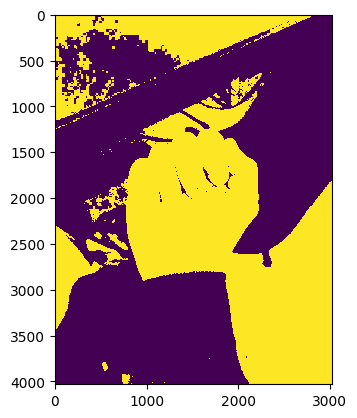

In [9]:
# Approche classique avec parcours de l'image
def isSkin(pixel):
    b = pixel[0]
    g = pixel[1]
    r = pixel[2]
    c1 = r > 95
    c2 = g > 40
    c3 = b > 20
    c4 = max(pixel) - min(pixel) > 15
    c4 = abs(int(r) - int(g)) > 15
    c5 = r > g
    c6 = r > b
    isSkin = c1 and c2 and c3 and c4 and c5 and c6
    return isSkin


def createSkinMask(src):
    img = cv2.imread(src, 1)
    height, width = img.shape[:2]
    mask = np.zeros((height, width), np.uint8)
    for i in range(height):
        for j in range(width):
            if isSkin(img[i][j]):
                mask[i][j] = 255
    return mask


skinMask = createSkinMask("./data/A_real.jpg")
plt.imshow(skinMask, interpolation="nearest")

In [14]:
def compterPixels(I, k):
    return np.count_nonzero((I == k))


def inverserImage(I):
    return 255 - I


def getImagesFromResources(skin_rep, color_space):
    skindir = os.path.dirname(skin_rep)
    print(skindir)
    skin_images = []
    for filename in os.listdir(skindir):
        img = cv2.imread(os.path.join(skindir, filename))
        if img is not None:
            if color_space == "BGR":
                skin_images.append(img)
            elif color_space == "Lab":
                skin_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2LAB))
            elif color_space == "HSV":
                skin_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
            elif color_space == "Gray":
                skin_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    return skin_images


skin_images = getImagesFromResources(
    "./data/Data/Face_Dataset/Pratheepan_Dataset/FacePhoto/", "Lab"
)
assert len(skin_images) == 32

mask_images = getImagesFromResources(
    "./data/Data/Face_Dataset/Ground_Truth/GroundT_FacePhoto/", "Gray"
)
assert len(mask_images) == 32


def create_histograms(color_space, size, skin_images, mask_images):
    if color_space in ["BGR", "Lab"]:
        # Creation de l'histogramme de peau
        hist_peau = [[0 for j in range(size)] for i in range(size)]
        hist_non_peau = [[0 for j in range(size)] for i in range(size)]
        nb_pixel_peau = 0
        nb_pixel_non_peau = 0
        for img in skin_images:
            nb_pixel_peau = nb_pixel_peau + compterPixels(mask_images[0], 255)
            nb_pixel_non_peau = nb_pixel_non_peau + compterPixels(mask_images[0], 0)
            hist_peau = hist_peau + cv2.calcHist(
                [skin_images[0]], [1, 2], mask_images[0], [size, size], [0, 256, 0, 256]
            )
            hist_non_peau = hist_non_peau + cv2.calcHist(
                [skin_images[0]],
                [1, 2],
                inverserImage(mask_images[0]),
                [size, size],
                [0, 256, 0, 256],
            )
        print(nb_pixel_peau)
        hist_peau = hist_peau / nb_pixel_peau
        hist_non_peau = hist_non_peau / nb_pixel_non_peau
        p_peau_prior = nb_pixel_peau / (nb_pixel_peau + nb_pixel_non_peau)
        p_non_peau_prior = nb_pixel_non_peau / (nb_pixel_peau + nb_pixel_non_peau)
    elif color_space == "HSV":
        hist_peau = [[0 for j in range(size)] for i in range(size)]
        hist_non_peau = [[0 for j in range(size)] for i in range(size)]
        nb_pixel_peau = 0
        nb_pixel_non_peau = 0
        for img in skin_images:
            nb_pixel_peau = nb_pixel_peau + compterPixels(mask_images[0], 255)
            nb_pixel_non_peau = nb_pixel_non_peau + compterPixels(mask_images[0], 0)
            hist_peau = hist_peau + cv2.calcHist(
                [skin_images[0]], [0, 1], mask_images[0], [size, size], [0, 180, 0, 256]
            )
            hist_non_peau = hist_non_peau + cv2.calcHist(
                [skin_images[0]],
                [0, 1],
                inverserImage(mask_images[0]),
                [size, size],
                [0, 180, 0, 256],
            )
        print(nb_pixel_peau)
        hist_peau = hist_peau / nb_pixel_peau
        hist_non_peau = hist_non_peau / nb_pixel_non_peau
        p_peau_prior = nb_pixel_peau / (nb_pixel_peau + nb_pixel_non_peau)
        p_non_peau_prior = nb_pixel_non_peau / (nb_pixel_peau + nb_pixel_non_peau)
    return hist_peau, hist_non_peau, p_peau_prior, p_non_peau_prior


hist_peau_RG, hist_non_peau_RG, peau_prior, non_peau_prior = create_histograms(
    "BGR",
    32,
    getImagesFromResources(
        "./data/Data/Face_Dataset/Pratheepan_Dataset/FacePhoto/", "BGR"
    ),
    getImagesFromResources(
        "./data/Data/Face_Dataset/Ground_Truth/GroundT_FacePhoto/", "Gray"
    ),
)

plt.imshow(hist_peau_RG, interpolation="nearest")
plt.show()
plt.imshow(hist_non_peau_RG, interpolation="nearest")
plt.show()

./data/Data/Face_Dataset/Pratheepan_Dataset/FacePhoto
25
./data/Data/Face_Dataset/Ground_Truth/GroundT_FacePhoto
25


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


AssertionError: 